In [1]:
import DSGRN
import DSGRN_utils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool
import os
import json
import time
from multiprocessing import cpu_count


In [2]:
from dsgrn_boolean.utils.hill_analysis import analyze_hill_coefficients
from dsgrn_boolean.utils.newton import newton_method
from dsgrn_boolean.utils.dsgrn_sample_to_matrix import extract_parameter_matrices
from dsgrn_boolean.utils.nullclines import plot_nullclines
from dsgrn_boolean.utils.interactive import plot_nullclines_interactive

from dsgrn_boolean.scripts.plot_phase_portrait import plot_phase_portrait

from dsgrn_boolean.utils.sample_management import load_samples
from dsgrn_boolean.utils.dsgrn_sample_to_matrix import extract_parameter_matrices
from dsgrn_boolean.models.hill import HillFunction, hill

from dsgrn_boolean.utils.sample_management import load_samples

In [3]:
from dsgrn_boolean.scripts.plot_hill_function import plot_hill_function

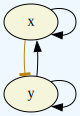

Number of parameter nodes: 196


In [4]:
net_spec = """x : x + y : E
              y : (~x) y : E"""

network = DSGRN.Network(net_spec)

G = DSGRN.DrawGraph(network)
display(G)

parameter_graph = DSGRN.ParameterGraph(network)

print('Number of parameter nodes:', parameter_graph.size())


In [5]:
par_list = [0, 49, 98, 147]

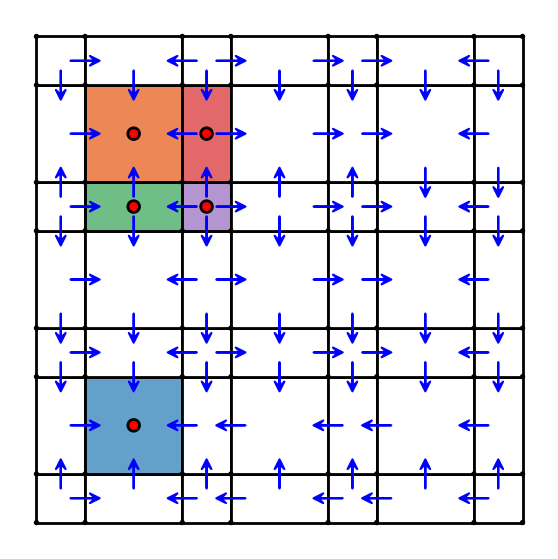

In [6]:
par_index = 0

parameter = parameter_graph.parameter(par_index)

# sampler = DSGRN.ParameterSampler(network)
# n_samples = 10000
samples = load_samples(par_index,filtered=True,filter_tol=0.1)
# samples = load_samples(par_index,filtered=True,filter_tol=1.0)
samples = samples[:100]

morse_graph, stg, graded_complex = DSGRN_utils.ConleyMorseGraph(parameter)
DSGRN_utils.PlotMorseSets(morse_graph, stg, graded_complex)

[[0.248221   0.54267305]
 [0.37755684 0.27815649]]
[[2.43685322 1.61306384]
 [3.50768316 1.07194536]]
[[4.16421358 4.47481994]
 [0.77830997 1.43026858]]


(<Figure size 1000x1000 with 1 Axes>, [array([0.6384194, 0.448696 ])])

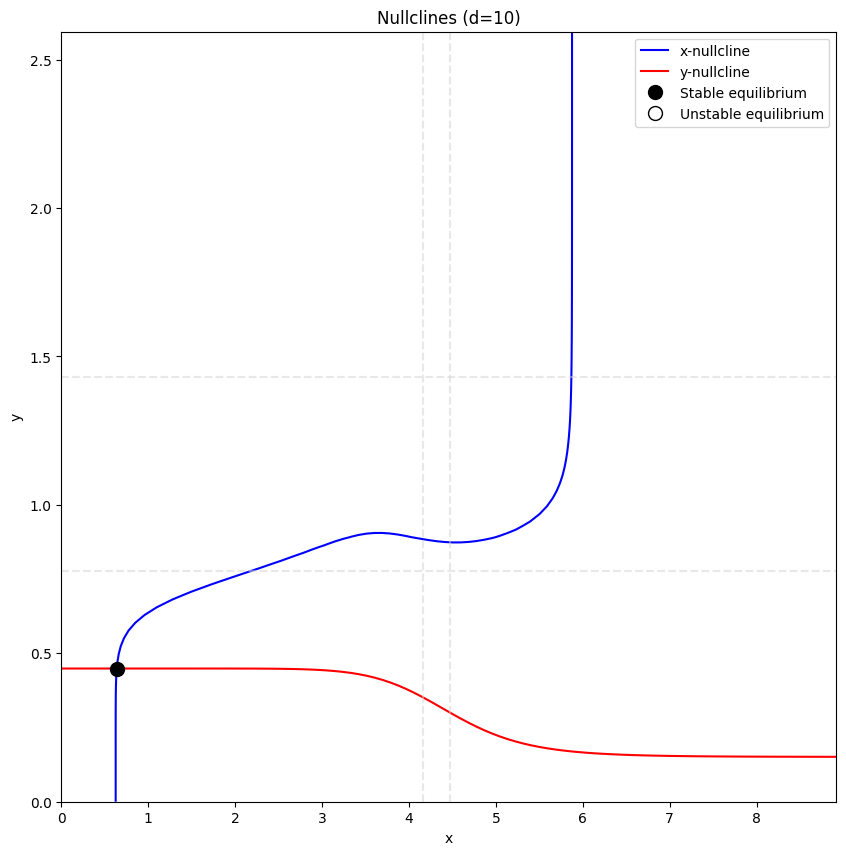

In [29]:
par_sample = samples[6]
L, U, T = extract_parameter_matrices(par_sample, network)
d_max = 20
# plot_nullclines_interactive(L, U, T, d_max, 100)
print(L)
print(U)
print(T)
plot_nullclines(L, U, T, 10, 100)

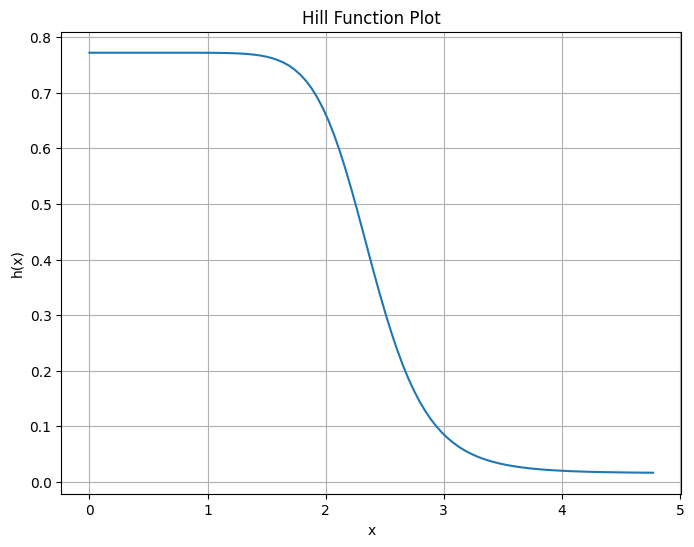

In [9]:
h01 = HillFunction(U[0,1], L[0,1], T[0,1], 10)
plot_hill_function(h01, T[0,1])

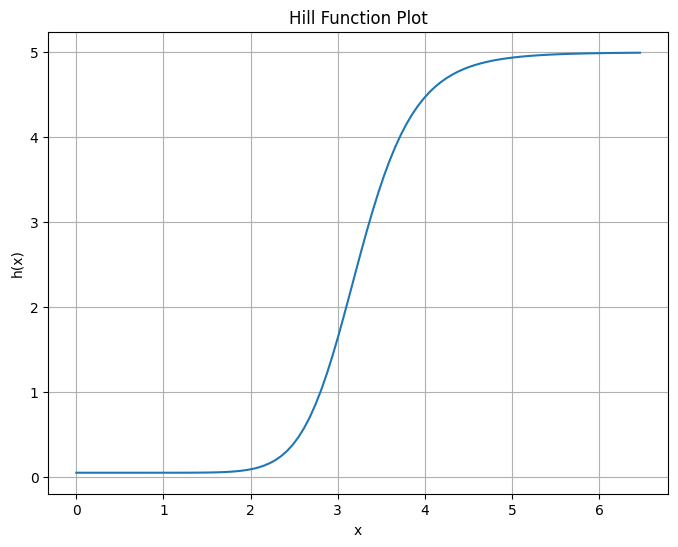

In [10]:
h11 = HillFunction(L[1,1], U[1,1], T[1,1], 10)
plot_hill_function(h11, T[1,1])

In [11]:
def plot_hill_product_3d(h01, h11, T, n_points=50):
    """
    Plots the 3D surface of the product of two Hill functions h01(x) * h11(y)
    from 0 to 2*T in both x and y.

    Args:
        h01 (HillFunction): The first Hill function (depends on x).
        h11 (HillFunction): The second Hill function (depends on y).
        T (float): The threshold value.
        n_points (int): Number of points to use for plotting in each dimension.
    """
    x = np.linspace(0, 2 * T, n_points)
    y = np.linspace(0, 2 * T, n_points)
    X, Y = np.meshgrid(x, y)
    Z = h01(X) * h11(Y)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("h01(x) * h11(y)")
    ax.set_title("3D Plot of Hill Function Product")

    plt.show()

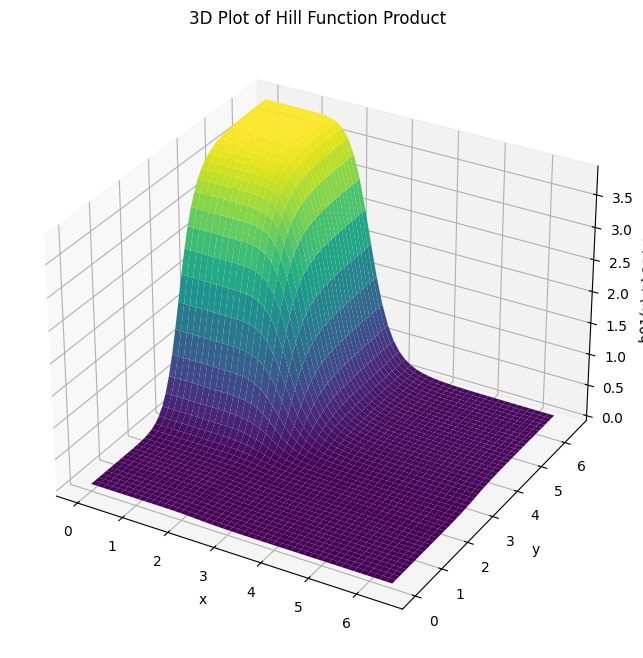

In [12]:
plot_hill_product_3d(h01, h11, max(T[0,1], T[1,1]))

In [13]:
print('L=',L)
print('U=',U)
print('T=',T)



L= [[0.18972007 0.01567368]
 [0.16050294 0.04746016]]
U= [[0.92892602 0.77211194]
 [1.57315078 5.00078358]]
T= [[2.0553359  2.38666454]
 [1.40385431 3.23511816]]


In [14]:
# Expected number of equilibria
expected_eq = len(DSGRN.EquilibriumCells(parameter))
print("expected_equilibria = ", expected_eq)

expected_equilibria =  5


In [15]:
def check_inequalities(L, U, T):
    inequalities = [
        (L[0, 0] + L[1, 0] < T[0, 0]),
        (U[0, 0] + L[1, 0] < T[0, 0]),
        (L[0, 0] + U[1, 0] < T[0, 0]),
        (T[0, 1] < U[0, 0] + U[1, 0]),
        (0 < T[0, 0] < T[0, 1]),
        (0 < L[0, 0] < U[0, 0]),
        (0 < L[1, 0] < U[1, 0]),
        (L[0, 1] * L[1, 1] < T[1, 1]),
        (U[0, 1] * L[1, 1] < T[1, 1]),
        (L[0, 1] * U[1, 1] < T[1, 1]),
        (T[1, 0] < U[0, 1] * U[1, 1]),
        (0 < T[1, 1] < T[1, 0]),
        (0 < L[0, 1] < U[0, 1]),
        (0 < L[1, 1] < U[1, 1]),
    ]

    results = {}
    for i, inequality in enumerate(inequalities):
        results[f"Inequality {i+1}"] = inequality

    return results

results = check_inequalities(L, U, T)
for inequality, result in results.items():
    print(f"{inequality}: {result}")

Inequality 1: True
Inequality 2: True
Inequality 3: True
Inequality 4: True
Inequality 5: True
Inequality 6: True
Inequality 7: True
Inequality 8: True
Inequality 9: True
Inequality 10: True
Inequality 11: True
Inequality 12: False
Inequality 13: True
Inequality 14: True


In [16]:
# TO-DO
# search just for the three stable points 
# pull the # from the level = 0 (morse set)
# for each point, look up just the grid corresponding to that morse-set

In [17]:
# d_range = range(200,201)

In [18]:
# # Let's do a few less samples lol 
# # samples_1000 = samples[:1000]
# # samples = samples[:1000]
# samples_100 = samples[:100]
# samples = samples_100

# # Use your pre-generated samples with sample tracking
# results, summary, optimal_d, sample_results = analyze_hill_coefficients(
#     network, 
#     parameter, 
#     samples, 
#     d_range
# )

# print(f"\nSummary:")
# print(f"Expected equilibria: {summary['expected_equilibria']}")
# print(f"Best match percentage: {summary['best_match']:.1f}% at d = {summary['best_match_d']}")
# print(f"Worst match percentage: {summary['worst_match']:.1f}% at d = {summary['worst_match_d']}")

In [19]:
# # Example: Check which samples matched at a specific d value
# d = 200  # Adjust this value based on your d_range
# print(f"\nAt d={d}:")
# print(f"Matching samples: {sample_results[d]['matches']}")
# print(f"Failed samples: {sample_results[d]['failures']}")

In [20]:
# # Example: Track a specific sample across all d values
# sample_id = sample_results[d]['failures'][0]  # You can change this to track different samples
# print(f"\nTracking sample {sample_id}:")
# matching_d = [d for d in d_range if sample_id in sample_results[d]['matches']]
# failing_d = [d for d in d_range if sample_id in sample_results[d]['failures']]
# print(f"Matching d values: {matching_d}")
# print(f"Failing d values: {failing_d}")

In [21]:
# par_sample = samples[sample_id]
# L, U, T = extract_parameter_matrices(par_sample, network)
# plot_nullclines_interactive(L, U, T, d)

In [22]:
# from dsgrn_boolean.utils.hill_stable_analysis import analyze_stability
# from dsgrn_boolean.utils.sample_management import load_samples

# # Load samples
# par_index = 98
# samples = load_samples(par_index)[:10]  # First 10 samples

# # Run analysis
# results = analyze_stability(
#     network, 
#     parameter,
#     samples,
#     d_range=range(100, 0, -5)  # Step by 5 for testing
# )